In [3]:
import sentiment as sentimentinterface
import classify
import numpy as np
from string import punctuation
import math
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import importlib

In [4]:
importlib.reload(sentimentinterface)
print("Reading data")
tarfname = "data/sentiment.tar.gz"
sentiment = sentimentinterface.read_data(tarfname)

Reading data
-- train data
sentiment/train.tsv
4582
-- dev data
sentiment/dev.tsv
458
-- transforming data and labels


In [5]:
# (diff, max_df, min_df, c) =  (0.4, 0.2, 3, 3.7)
stop_words = sentimentinterface.generate_stop_words(sentiment, diff = 0.4)
sentimentinterface.vectorize_data(sentiment, stop_words = stop_words, max_df = 0.2, min_df = 3)
clf = classify.train_classifier(sentiment.trainX, sentiment.trainy, C = 3.7)

In [6]:
# Logistic Regression Interception
intercept = copy.deepcopy(clf.intercept_)[0]

# Vectorizer vocaulary list (ordered)
cv = sentiment.count_vect.vocabulary_
cv = [(v,w) for w,v in cv.items()]
cv.sort()
cv = [x[1] for x in cv]

In [7]:
word_coef = [x for x in zip(clf.coef_[0], cv)]

In [8]:
word_coef.sort()
word_coef[:10]

[(-6.236509599547909, 'worst'),
 (-5.849376307513409, 'horrible'),
 (-4.622805512805428, 'terrible'),
 (-4.039673574846966, 'disappointing'),
 (-3.9136279315792804, 'rude'),
 (-3.7218408353549703, 'average'),
 (-3.4298865570894104, 'meh'),
 (-3.322794263373309, 'not'),
 (-3.200530073833454, 'excited'),
 (-3.1159567963289247, 'disappointed')]

In [9]:
word_coef[-10:]

[(2.9907539118997843, 'perfect'),
 (3.1447662515475074, 'pleased'),
 (3.22100858565887, 'easy'),
 (3.3884539796897406, 'love'),
 (3.8361050055149755, 'awesome'),
 (3.875006768459051, 'best'),
 (3.8873314064473514, 'delicious'),
 (4.738760971635922, 'great'),
 (4.8693649748011, 'amazing'),
 (4.97161066870239, 'excellent')]

In [10]:
x_raw = sentiment.trainX[0]
print(sentiment.trainX[0])

  (0, 2066)	0.2697698546275474
  (0, 1046)	0.3692993219851098
  (0, 1614)	0.4136859083401055
  (0, 1997)	0.4625903417680006
  (0, 1247)	0.21040915978272207
  (0, 1282)	0.30151551547563205
  (0, 1204)	0.5201276388218082


In [11]:
def clean(s):
    
    s_new = []
    for c in s:
        
        # Remove punctuation
        if c not in punctuation:
            
            # To lower
            s_new.append(c.lower())
        else:
            s_new.append(' ')
            
    s = ''.join(c for c in s_new)
            
    # Remove out of vocab words
    l = s.split()
    l = [w for w in l if w in sentiment.count_vect.vocabulary_]
    
    return l
 
x = sentiment.train_data[0]
x_new = clean(x)
len(set(x_new))
x_new

['went', 'let', 'saying', 'vegetarian', 'not', 'ordered', 'mushroom']

In [12]:
def bar_chart(cd, title='',ylabel=''):
    
    words = [w for w,_ in cd.items()]
    coefs = [cd[w] for w in words]
    l = [x for x in zip(coefs, words)]
    l.sort()
    words = [w for c,w in l]
    coefs = [c for c,w in l]

    fig = plt.figure(figsize=(15,5))
    colors = ['red' if c < 0 else 'blue' for c in coefs]
    plt.bar(words, coefs, color=colors)
    plt.xlabel('Word', fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xticks(fontsize=20, rotation=30)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize = 30)
    plt.show()
    
    return fig

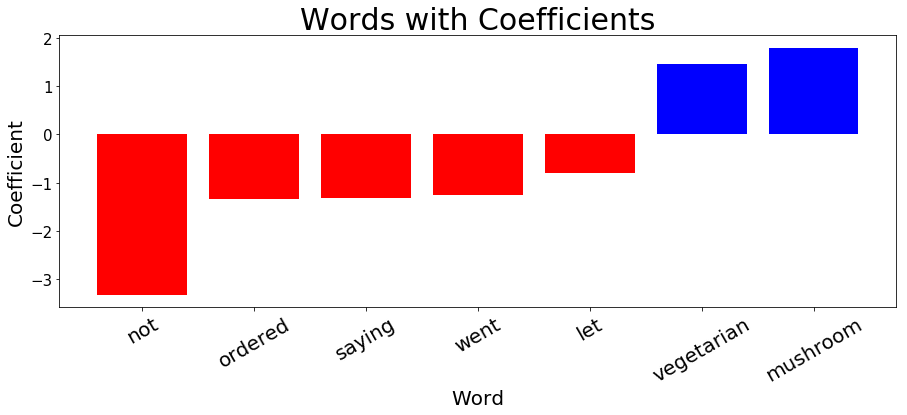

In [428]:
def coef_list(words):
    d = {}
    for w in words:
        c = clf.coef_[0][sentiment.count_vect.vocabulary_[w]]
        d[w] = c
        
    return d

cd = coef_list(x_new)
f1 = bar_chart(cd, 'Words with Coefficients', 'Coefficient')

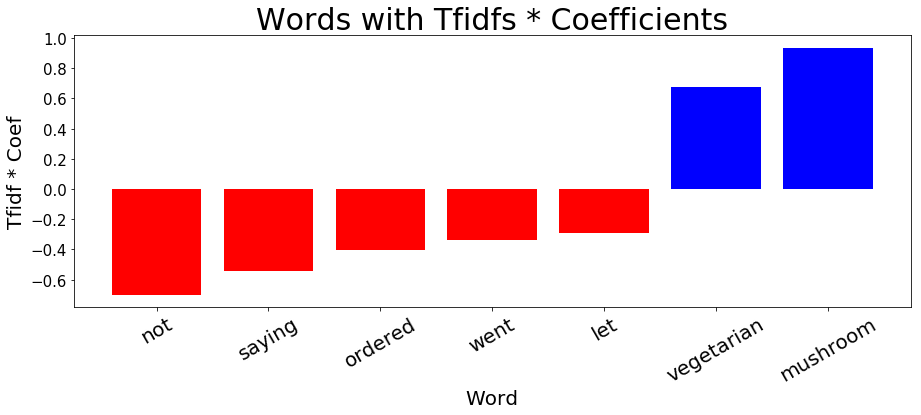

In [429]:
def tfidf_x_coef(x):
    
    cd = {}
    for i,v in zip(x.indices, x.data):
        cd[cv[i]] = clf.coef_[0][i] * v
        
    return cd

cd = tfidf_x_coef(x_raw)
f2 = bar_chart(cd, 'Words with Tfidfs * Coefficients', 'Tfidf * Coef')

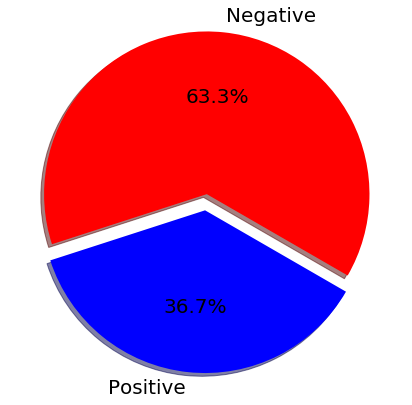

In [430]:
def prob(x):
    
    z = intercept
    for i,v in zip(x.indices, x.data):
        z += clf.coef_[0][i] * v
        
    pos = 1 / (1 + math.exp(-z))
    neg = 1 - pos
    
    return [neg,pos]

def pie_chart(probs):
    
    mpl.rcParams['font.size'] = 20
    
    fig = plt.figure(figsize=(7,7))
    labels = ["Negative", "Positive"]
    colors = ['red', 'blue']
    explode = (0.1, 0)
    plt.pie(probs, labels=labels, colors=colors,shadow=True, explode=explode,
            autopct='%1.1f%%', startangle=-30)
    plt.axis('equal')
    plt.show()
    
    return fig
        
probs = prob(x_raw)
f3 = pie_chart(probs)

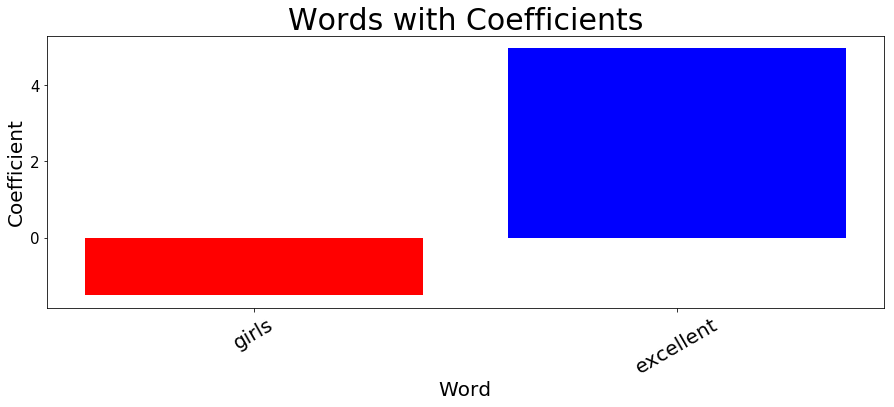

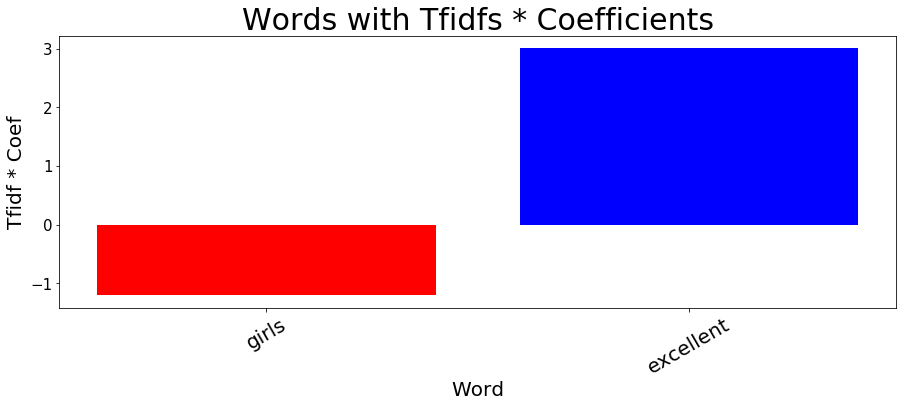

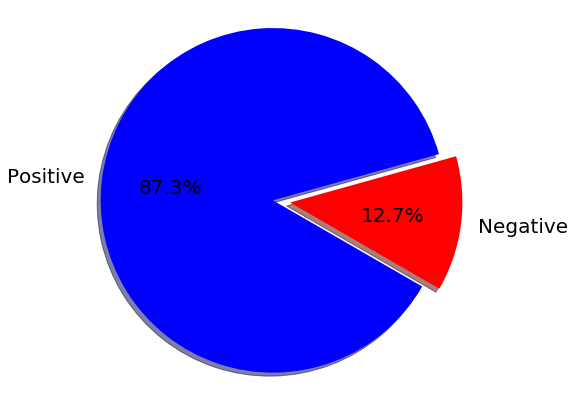

In [431]:
def generate_graphs(sentence):
    
    figs = []
    x = clean(sentence)
    
    cd = coef_list(x)
    f1 = bar_chart(cd, 'Words with Coefficients', 'Coefficient')
    figs.append(f1)

    x_vec = sentiment.count_vect.transform([sentence])
    cd = tfidf_x_coef(x_vec)
    f2 = bar_chart(cd, 'Words with Tfidfs * Coefficients', 'Tfidf * Coef')
    figs.append(f2)

    probs = prob(x_vec)
    f3 = pie_chart(probs)
    figs.append(f3)
    
    return figs

sentence = "I have an excellent meal here! But the girls are too load."
figs = generate_graphs(sentence)